## Create Saliency maps with COVID-NET model

Christine Swisher 
April 14, 2020

In [1]:
# Boilerplate imports.
import tensorflow.compat.v1 as tf
import numpy as np
import cv2
import PIL.Image
from matplotlib import pylab as P
import pickle
import os
# slim=tf.contrib.slim
# 1. Install tf_slim using: pip install git+https://github.com/adrianc-a/tf-slim.git@remove_contrib
# 2. Replace imports of slim with import tf_slim as slim 
#    in the models/research/slim folder - in inception_v3.py and inception_utils.py.
import tf_slim as slim
import matplotlib.pyplot as plt

if not os.path.exists('models/research/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/research/slim')
from nets import inception_v3
os.chdir(old_cwd)

# From our repository.
import saliency

%matplotlib inline

## Utility methods

In [23]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
#     im = ((im + 1) * 127.5).astype(np.uint8)
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
    if ax is None:
        fig, ax = P.subplots()
    else:
        fig = ax.figure
  
    P.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im / 127.5 - 1.0

## Load image and run inference - vanilla model

In [3]:
# Use either wget or curl depending on your OS.
if not os.path.exists('inception_v3.ckpt'):
  #!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !curl -O http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !tar -xvzf inception_v3_2016_08_28.tar.gz

ckpt_file = './inception_v3.ckpt'

In [5]:
graph = tf.Graph()

with graph.as_default():
    images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
        _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)

        # Restore the checkpoint
        sess = tf.Session(graph=graph)
        saver = tf.train.Saver()
        saver.restore(sess, ckpt_file)

    # Construct the scalar neuron tensor.
    logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[0][neuron_selector]

    # Construct tensor for predictions.
    prediction = tf.argmax(logits, 1)

INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


In [13]:
imagepath   = '/home/cswisher/COVID-Net/assets/ex-covid.jpeg'

# Load the image
x = cv2.imread(imagepath)
x = cv2.resize(x, (299, 299))
im = x.astype('float32') / 255.0

# Make a prediction. 
prediction_class = sess.run(prediction, feed_dict = {images: [im]})[0]

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 237

Prediction class: 605


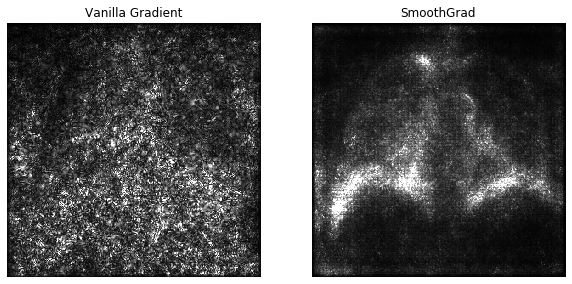

In [14]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

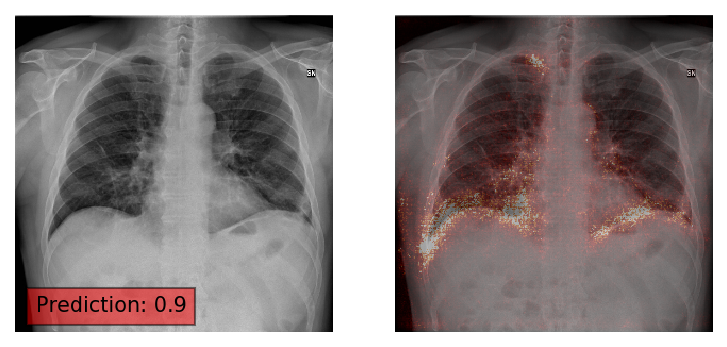

DISCLAIMER: this is nonsense - just looking at edges. Prediction is made up


In [49]:
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(im)
plt.axis('off')
plt.text(19,280, 'Prediction: {}'.format(0.9), bbox=dict(facecolor='red', alpha=0.5))
plt.subplot(122)
plt.imshow(im)
plt.imshow(smoothgrad_mask_grayscale,cmap=plt.cm.gist_heat, alpha=.3)
plt.axis('off')
plt.show()
print('DISCLAIMER: this is nonsense - just looking at edges. Prediction is made up')

# REAL COVID PNEUMONIA MODEL

## Load image and run inference - COVID model

In [3]:
weightspath = '/home/cswisher/COVID-Net/COVID-Net-Large'   
metaname    = 'model.meta_eval'
ckptname    = 'model-2069'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}

sess = tf.Session()
tf.get_default_graph()
saver = tf.train.import_meta_graph(os.path.join(weightspath, metaname))
saver.restore(sess, os.path.join(weightspath, ckptname))

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/cswisher/COVID-Net/COVID-Net-Large/model-2069


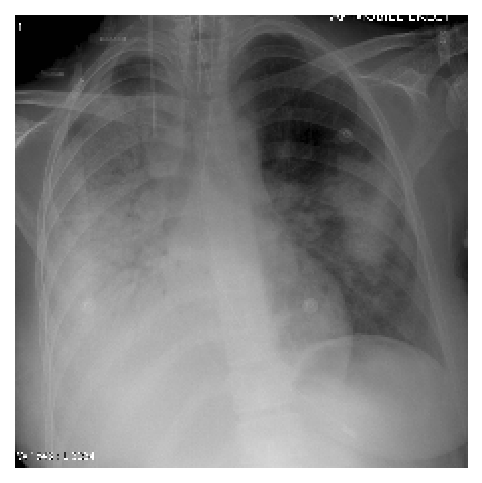

Prediction: pneumonia
Confidence
Normal: 0.000, Pneumonia: 0.999, COVID-19: 0.000


In [223]:
# Specify inputs and outputs
image_tensor = graph.get_tensor_by_name("input_1:0")
pred_tensor = graph.get_tensor_by_name("dense_3/Softmax:0")

# Construct the scalar neuron tensor.
logits = graph.get_tensor_by_name('dense_3/Softmax:0')
neuron_selector = tf.placeholder(tf.int32)
y = logits[0][neuron_selector]

# Construct tensor for predictions.
prediction = tf.argmax(logits, 1)

imagepath   = '/home/cswisher/COVID-Net/data/test/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg' ##Pneumonia 
#'/home/cswisher/COVID-Net/data/test/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg' ##covid
#'/home/cswisher/COVID-Net/data/test/covid-19-pneumonia-15-PA.jpg' ##covid
#'/home/cswisher/COVID-Net/assets/ex-covid.jpeg' ##covid
#'/home/cswisher/COVID-Net/data/test/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg' ##covid
#'/home/cswisher/COVID-Net/data/test/1-s2.0-S0929664620300449-gr2_lrg-d.jpg' ##covid
#'/home/cswisher/COVID-Net/data/test/14f29678-d258-4cef-bd42-352070353966.png' ##covid
#'/home/cswisher/COVID-Net/data/test/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg' ##Pneumonia 


x = cv2.imread(imagepath)
x = cv2.resize(x, (224, 224))
x = x.astype('float32') / 255.0

im = np.expand_dims(x, axis=0)

pred = sess.run(pred_tensor, feed_dict={image_tensor: im})

prediction_class = pred.argmax(axis=1)[0]

plt.figure(dpi=150)
plt.imshow(x)
plt.axis('off')
plt.show()

print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
print('Confidence')
print('Normal: {:.3f}, Pneumonia: {:.3f}, COVID-19: {:.3f}'.format(pred[0][0], pred[0][1], pred[0][2]))

## XRAI Fast

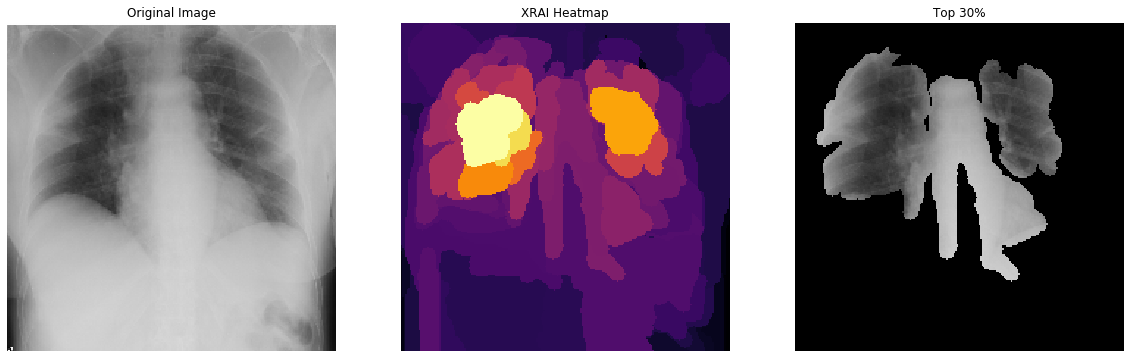

In [163]:

# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
xrai_object = saliency.XRAI(graph, sess, y, image_tensor)

# Compute XRAI attributions with default parameters
xrai_attributions_covid = xrai_object.GetMask(x, feed_dict={neuron_selector: 2})
xrai_attributions_pneum = xrai_object.GetMask(x, feed_dict={neuron_selector: 1})


# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(x, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_covid, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_covid > np.percentile(xrai_attributions_covid, 70)
im_mask = np.array(x)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

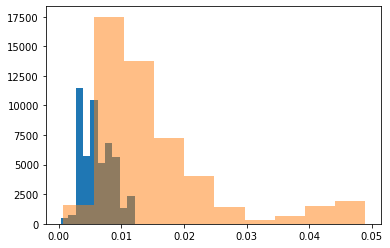

In [179]:
plt.hist(xrai_attributions_pneum.flatten(), label = 'pneum')
plt.hist(xrai_attributions_covid.flatten(), label = 'covid', alpha = .75)
plt.show()

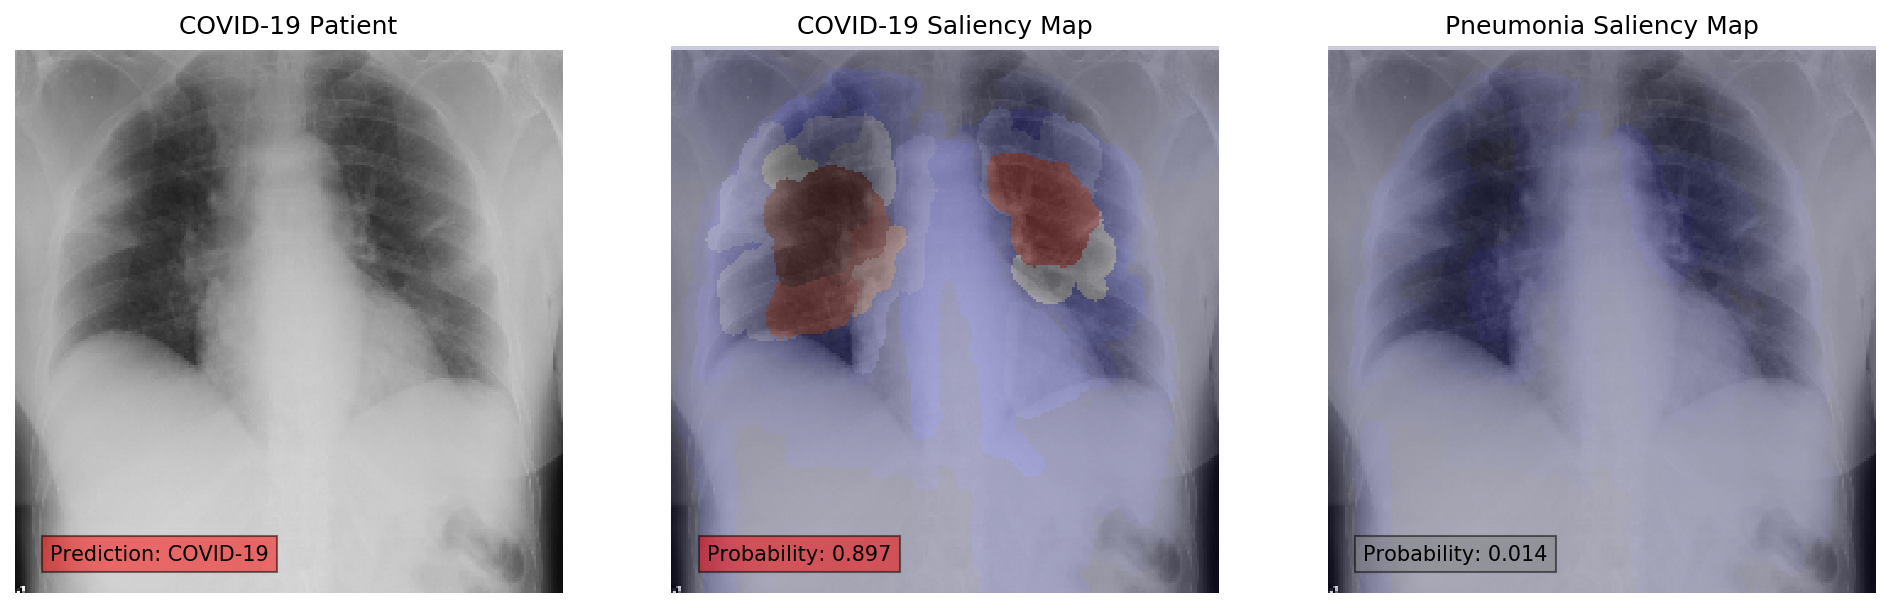

Prediction is COVID-19
Confidence - Normal: 0.089, Pneumonia: 0.014, COVID-19: 0.897


In [222]:
# xrai_attributions_overlay = xrai_attributions * pred[0][prediction_class]
colormap = plt.cm.seismic
alpha = 0.2

plt.figure(figsize = (16,12), dpi=150)
plt.subplot(231)
plt.imshow(x)
plt.axis('off')
plt.text(14,210, 'Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]),  
         bbox=dict(facecolor='red', alpha=0.5))
plt.title('COVID-19 Patient')
plt.subplot(232)
plt.imshow(x)
plt.imshow(xrai_attributions_covid,cmap=colormap, alpha=alpha, 
           clim=[np.percentile(xrai_attributions_covid,20), xrai_attributions_covid.max()])
plt.text(14,210, 'Probability: {:.3f}'.format(pred[0][2]), bbox=dict(facecolor='red', alpha=.5))
plt.title('COVID-19 Saliency Map')
plt.axis('off')
plt.subplot(233)
plt.imshow(x)
plt.imshow(xrai_attributions_pneum,cmap=colormap, alpha=alpha, 
           clim=[np.percentile(xrai_attributions_pneum,20), xrai_attributions_covid.max()])
plt.text(14,210, 'Probability: {:.3f}'.format(pred[0][1]), bbox=dict(facecolor='grey', alpha=.5))
plt.title('Pneumonia Saliency Map')
plt.axis('off')

plt.show()
print('Prediction is {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
print('Confidence - Normal: {:.3f}, Pneumonia: {:.3f}, COVID-19: {:.3f}'.format(pred[0][0], pred[0][1], pred[0][2]))

In [ ]:
# xrai_attributions_overlay = xrai_attributions * pred[0][prediction_class]

plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(x)
plt.axis('off')
plt.text(14,210, 'Prediction: {:.3f}'.format(pred[0][prediction_class]), 
         bbox=dict(facecolor='red', alpha=0.5))
plt.subplot(122)
plt.imshow(x)
plt.imshow(xrai_attributions_overlay,cmap=plt.cm.inferno, alpha=.3, clim=[np.percentile(xrai_attributions_overlay,70), xrai_attributions_overlay.max()])
plt.axis('off')
# plt.subplot(223)
# plt.imshow(xrai_attributions, cmap='inferno')
# plt.axis('off')


plt.show()


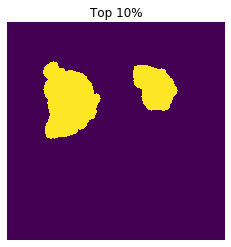

In [135]:
# Show most salient 10% of the image
mask_70 = xrai_attributions > np.percentile(xrai_attributions, 90)
mask_80 = xrai_attributions > np.percentile(xrai_attributions, 90)
mask_90 = xrai_attributions > np.percentile(xrai_attributions, 90)



im_mask = np.array(x)
im_mask[~mask] = 0
ShowImage(mask, title='Top 10%')


### Vanilla Gradient & SmoothGrad

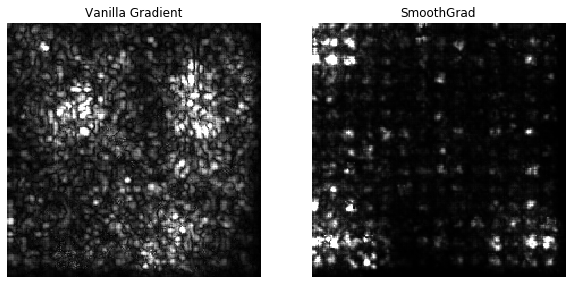

In [95]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = saliency.GradientSaliency(graph, sess, y, image_tensor)

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(x, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(x, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

### Guided Backprop & SmoothGrad

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


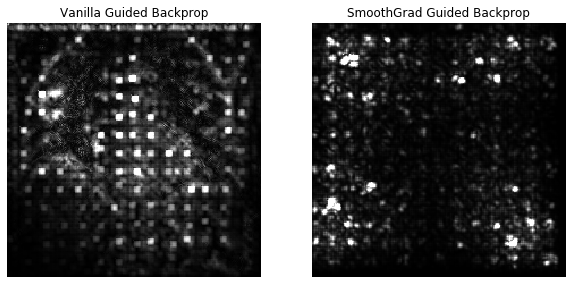

In [96]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = saliency.GuidedBackprop(graph, sess, y, image_tensor)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
  x, feed_dict = {neuron_selector: prediction_class})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
  x, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

## Integrated Gradients & SmoothGrad

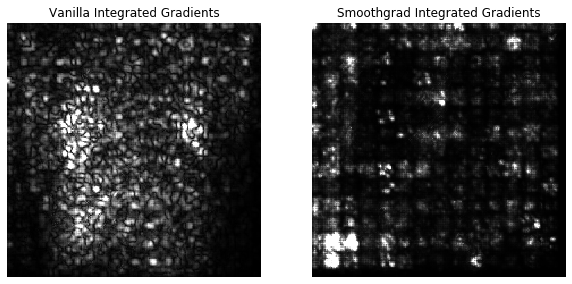

In [68]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = saliency.IntegratedGradients(graph, sess, y, image_tensor)

# Baseline is a black image.
baseline = np.zeros(x.shape)
baseline.fill(-1)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  x, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  x, feed_dict = {neuron_selector: prediction_class}, x_steps=25, x_baseline=baseline)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

# XRAI Full

In [69]:
# Create XRAIParameters and set the algorithm to fast mode which will produce an approximate result.
xrai_params = saliency.XRAIParameters()
xrai_params.algorithm = 'fast'

# Compute XRAI attributions with fast algorithm
xrai_attributions_fast = xrai_object.GetMask(x, feed_dict={neuron_selector: prediction_class}, extra_parameters=xrai_params)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(x, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions_fast, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions_fast > np.percentile(xrai_attributions_fast, 70)
im_mask = np.array(x)
im_mask[~mask] = 0

ShowImage(im_mask, 'Top 30%', ax=P.subplot(ROWS, COLS, 3))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype int32
	 [[node Placeholder_1 (defined at /home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'Placeholder_1':
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3242, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-a995f69e0f90>", line 7, in <module>
    neuron_selector = tf.placeholder(tf.int32)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/cswisher/.conda/envs/hlx-dl/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(x, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 10% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 90)
im_mask = np.array(x)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

## TODO Make this pretty